In [2]:
# tensorboard --logdir='runs/'
# %pip install seaborn
# https://d-qhdm1npvc0dx.studio.us-west-2.sagemaker.aws/jupyter/default/proxy/6006/#timeseries
# %pip install IProgress


[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [3]:
from datetime import datetime as dt
from itertools import chain
import os
import numpy as np
import pandas as pd
import torch

from tqdm import tqdm, trange
from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt
import seaborn as sns
import hephaestus as hp


torch.manual_seed(4242)
# Load and preprocess the dataset (assuming you have a CSV file)
df = pd.read_csv("../data/diamonds.csv")
df.head()

,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


In [4]:
dataset = hp.TabularDS(df, target_column="price")

In [5]:
model = hp.TabTransformer(dataset, n_heads=8).to(dataset.device)

batch_size = 3
test_num = dataset.X_train_numeric[0:batch_size, :]
test_num_mask = hp.mask_tensor(test_num, model)
test_cat = dataset.X_test_categorical[0:batch_size, :]
test_cat_mask = hp.mask_tensor(test_cat, model)
with torch.no_grad():
    x = model(
        test_num_mask,
        test_cat_mask,
        task="mlm",
    )
x[0].shape, x[1].shape

(torch.Size([3, 9, 33]), torch.Size([3, 6]))

In [6]:
board_writer = SummaryWriter(log_dir="runs/ModelGraph/first_graph")
board_writer.add_graph(model, (test_num_mask, test_cat_mask))

In [7]:
import torch

torch.nn.MultiheadAttention

torch.nn.modules.activation.MultiheadAttention

In [8]:
test_num.shape

torch.Size([3, 6])

In [9]:
# hp.show_mask_pred(0, model, dataset, probability=0.8)

In [10]:
# Masked Tabular Modeling
base_model_name = "FineTuneTesting"

model_time = dt.now()
model_time = model_time.strftime("%Y-%m-%dT%H:%M:%S")
model_name = f"{base_model_name}_{model_time}"

model_save_path = "./models/MTM_PreTrainTesting.pt"
remove_old_checkpoints = True
try:
    if remove_old_checkpoints:
        os.system(f"rm {model_save_path}")
except Exception as e:
    print("No Model")

In [11]:
model_list = os.listdir("./models")
if model_save_path.split("/")[-1] in model_list:
    print("Model already exists")
    model_exists = True
else:
    print("Model does not exist")
    model_exists = False

if model_exists:
    model.load_state_dict(torch.load(model_save_path))
    # model = torch.compile(model)
else:
    # model = torch.compile(model)
    hp.mtm(
        model, dataset, model_name, epochs=300, batch_size=1000, lr=0.001, patience=20
    )
    torch.save(model.state_dict(), model_save_path)

Model does not exist


Epoch 138/300 Loss: 0.6773 Test Loss: 0.8557 Early Stopping: Stopped on 20:  46%|████▌     | 137/300 [03:53<04:38,  1.71s/it]


In [12]:
# regression_performance = hp.fine_tune_model(
#     model, dataset, model_name="FT100", n_rows=100, epochs=100
# )
# regression_performance Epoch 200/200 Loss: 0.4529 Test Loss: 0.7390 Early Stopping: 8/40: 100%

In [13]:
n_train_rows = [
    # 10,
    100,
    1_000,
    2_000,
    5_000,
    10_000,
    15_000,
    30_000,
    # 40_000,
    dataset.X_train.shape[0],
]

In [14]:
def train_multiple_sizes(pt_model_path, dataset, n_train_rows, n_epochs=100):
    model = hp.TabTransformer(dataset, n_heads=8).to(dataset.device)
    if pt_model_path is not None:
        model.load_state_dict(torch.load(pt_model_path))

    regression_performance = hp.fine_tune_model(
        model,
        dataset,
        model_name=f"ft_{n_train_rows}",
        n_rows=n_train_rows,
        epochs=n_epochs,
        patience=20,
    )

    return regression_performance

In [15]:
hephaestus_results_no_pre_train = []
pbar = tqdm(n_train_rows)
for i in pbar:
    pbar.set_description(f"n_rows: {i}")
    loss = train_multiple_sizes(None, dataset, i, n_epochs=250)
    hephaestus_results_no_pre_train.append(loss)

Epochs, Model: ft_100_100_2023-09-11T14:26:37:   0%|          | 0/250 [00:00<?, ?it/s]
Epoch 1/250 n_rows: 100 Loss: 31,081,302.00 Test Loss: 31,736,454.00 Early Stopping: 0/20:   0%|          | 0/250 [00:00<?, ?it/s]
Epoch 2/250 n_rows: 100 Loss: 31,006,710.00 Test Loss: 31,629,726.00 Early Stopping: 0/20:   0%|          | 0/250 [00:00<?, ?it/s]
Epoch 3/250 n_rows: 100 Loss: 30,898,572.00 Test Loss: 31,514,916.00 Early Stopping: 0/20:   0%|          | 0/250 [00:00<?, ?it/s]
Epoch 3/250 n_rows: 100 Loss: 30,898,572.00 Test Loss: 31,514,916.00 Early Stopping: 0/20:   1%|          | 3/250 [00:00<00:08, 29.47it/s]
Epoch 4/250 n_rows: 100 Loss: 30,782,400.00 Test Loss: 31,375,464.00 Early Stopping: 0/20:   1%|          | 3/250 [00:00<00:08, 29.47it/s]
Epoch 5/250 n_rows: 100 Loss: 30,641,100.00 Test Loss: 31,199,864.00 Early Stopping: 0/20:   1%|          | 3/250 [00:00<00:08, 29.47it/s]
Epoch 6/250 n_rows: 100 Loss: 30,463,136.00 Test Loss: 30,992,892.00 Early Stopping: 0/20:   1%|       

In [16]:
no_pt_df = pd.DataFrame(hephaestus_results_no_pre_train)
no_pt_df["model"] = "Hephaestus No Fine Tune"
no_pt_df

,n_rows,test_loss,model
0,100,1.747827e+06,Hephaestus No Fine Tune
1,1000,4.894129e+05,Hephaestus No Fine Tune
2,2000,4.678263e+05,Hephaestus No Fine Tune
3,5000,3.853606e+05,Hephaestus No Fine Tune
4,10000,3.558663e+05,Hephaestus No Fine Tune
5,15000,3.392540e+05,Hephaestus No Fine Tune
6,30000,3.215759e+05,Hephaestus No Fine Tune
7,43152,3.178128e+05,Hephaestus No Fine Tune


In [17]:
# loss = regression_performance = hp.fine_tune_model(
#     model,
#     dataset,
#     model_name=f"ft_{n_train_rows}",
#     n_rows=1000,
#     epochs=150,
#     early_stop=True,
# )
# loss  # 15_629_481.0

In [ ]:
hephaestus_results = []
pbar = tqdm(n_train_rows)
for i in pbar:
    pbar.set_description(f"n_rows: {i}")
    loss = train_multiple_sizes(model_save_path, dataset, i, n_epochs=250)
    hephaestus_results.append(loss)

In [19]:
hephaestus_df = pd.DataFrame(hephaestus_results)
hephaestus_df["model"] = "Hephaestus"
hephaestus_df

,n_rows,test_loss,model
0,100,1.065145e+06,Hephaestus
1,1000,4.640315e+05,Hephaestus
2,2000,4.211280e+05,Hephaestus
3,5000,3.902659e+05,Hephaestus
4,10000,3.389955e+05,Hephaestus
5,15000,3.391630e+05,Hephaestus
6,30000,2.965145e+05,Hephaestus
7,43152,3.033654e+05,Hephaestus


In [20]:
hephaestus_df.loc[hephaestus_df.n_rows == 1000, "test_loss"].values

array([464031.46875])

In [21]:
# evaluation_df = hp.regression_actuals_preds(model, dataset)

In [22]:
# evaluation_df

In [23]:
%pip install xgboost



[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [24]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error

# Load the diamonds dataset
diamonds_data = pd.read_csv("../data/diamonds.csv")

# Encode categorical features using LabelEncoder
label_encoders = {}
categorical_features = ["cut", "color", "clarity"]
for feature in categorical_features:
    le = LabelEncoder()
    diamonds_data[feature] = le.fit_transform(diamonds_data[feature])
    label_encoders[feature] = le

# Split the dataset into features (X) and target (y)
X = diamonds_data.drop("price", axis=1)
y = diamonds_data["price"]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Initialize and train the XGBoost regressor
xgb_regressor = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
xgb_regressor.fit(
    X_train[0:batch_size],
    y_train[0:batch_size],
)

# Predict on the test set
y_pred = xgb_regressor.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse:,.2f}")

# You can also access feature importance scores
# feature_importances = xgb_regressor.feature_importances_
# print("Feature Importance:")
# for feature, importance in zip(X.columns, feature_importances):
#     print(f"{feature}: {importance:.4f}")

Mean Squared Error: 10,090,469.67


In [25]:
def xgb_tester(train_set_size):
    xgb_regressor = XGBRegressor(n_estimators=120, learning_rate=0.1, random_state=42)
    xgb_regressor.fit(
        X_train[0:train_set_size],
        y_train[0:train_set_size],
    )

    y_pred = xgb_regressor.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    return {"n_rows": train_set_size, "test_loss": mse}


xgb_losses = []
for i in tqdm(n_train_rows):
    mse = xgb_tester(i)
    xgb_losses.append(mse)

100%|██████████| 8/8 [00:05<00:00,  1.38it/s]


In [26]:
xgb_df = pd.DataFrame(xgb_losses)
xgb_df["model"] = "XGBoost"

xgb_df

,n_rows,test_loss,model
0,100,1.821790e+06,XGBoost
1,1000,6.689381e+05,XGBoost
2,2000,4.860844e+05,XGBoost
3,5000,3.809045e+05,XGBoost
4,10000,3.400657e+05,XGBoost
5,15000,3.165070e+05,XGBoost
6,30000,2.926587e+05,XGBoost
7,43152,2.763601e+05,XGBoost


In [27]:
loss_df = pd.concat([hephaestus_df, xgb_df, no_pt_df])  # , no_pt_df
loss_df = loss_df.loc[loss_df["n_rows"] != 10]
loss_df.sample(10)

,n_rows,test_loss,model
2,2000,467826.312500,Hephaestus No Fine Tune
6,30000,296514.468750,Hephaestus
3,5000,385360.562500,Hephaestus No Fine Tune
2,2000,486084.442709,XGBoost
6,30000,321575.937500,Hephaestus No Fine Tune
7,43152,303365.375000,Hephaestus
1,1000,464031.468750,Hephaestus
4,10000,338995.468750,Hephaestus
1,1000,489412.937500,Hephaestus No Fine Tune
1,1000,668938.114094,XGBoost


In [28]:
write_time = dt.now().strftime("%Y-%m-%dT%H:%M:%S")
loss_df.to_csv(f"../data/HepheastusLoss{write_time}.csv")

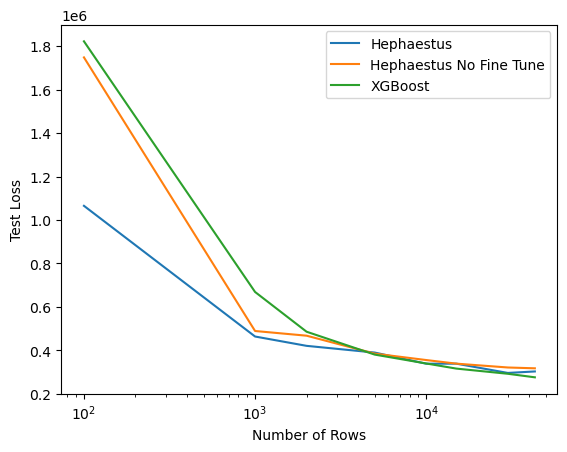

In [29]:
# Define the colors for each model
# colors = {"Hephaestus": "blue", "XGBoost": "red"}

# Create a figure and axis object
fig, ax = plt.subplots()

# Loop through each model and plot the test loss as a line
for model, group in loss_df.groupby("model"):
    ax.plot(group["n_rows"], group["test_loss"], label=model)

# Set the axis labels and legend
ax.set_xlabel("Number of Rows")
ax.set_ylabel("Test Loss")
ax.legend()
# set x axis to log scale
ax.set_xscale("log")

# Show the plot
plt.show()

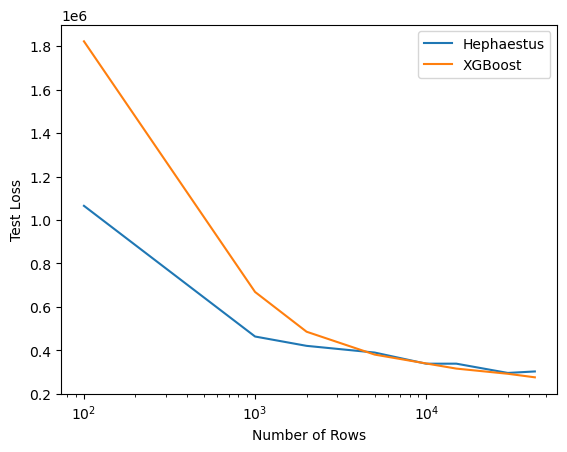

In [30]:
# Define the colors for each model
# colors = {"Hephaestus": "blue", "XGBoost": "red"}

# Create a figure and axis object
fig, ax = plt.subplots()

# Loop through each model and plot the test loss as a line
for model, group in loss_df.loc[loss_df["model"] != "Hephaestus No Fine Tune"].groupby(
    "model"
):
    ax.plot(group["n_rows"], group["test_loss"], label=model)

# Set the axis labels and legend
ax.set_xlabel("Number of Rows")
ax.set_ylabel("Test Loss")
ax.legend()
# set x axis to log scale
ax.set_xscale("log")

# Show the plot
plt.show()

In [31]:
# Spread the data to have columns for the loss of each model
# loss_df =
loss_percent_df = loss_df.pivot(
    index="n_rows", columns="model", values="test_loss"
).reset_index()
loss_percent_df["percent_improvement"] = (
    loss_percent_df["XGBoost"] - loss_percent_df["Hephaestus"]
) / loss_percent_df["XGBoost"]

In [32]:
loss_percent_df

model,n_rows,Hephaestus,Hephaestus No Fine Tune,XGBoost,percent_improvement
0,100,1.065145e+06,1.747827e+06,1.821790e+06,0.415330
1,1000,4.640315e+05,4.894129e+05,6.689381e+05,0.306316
2,2000,4.211280e+05,4.678263e+05,4.860844e+05,0.133632
3,5000,3.902659e+05,3.853606e+05,3.809045e+05,-0.024577
4,10000,3.389955e+05,3.558663e+05,3.400657e+05,0.003147
5,15000,3.391630e+05,3.392540e+05,3.165070e+05,-0.071581
6,30000,2.965145e+05,3.215759e+05,2.926587e+05,-0.013175
7,43152,3.033654e+05,3.178128e+05,2.763601e+05,-0.097718


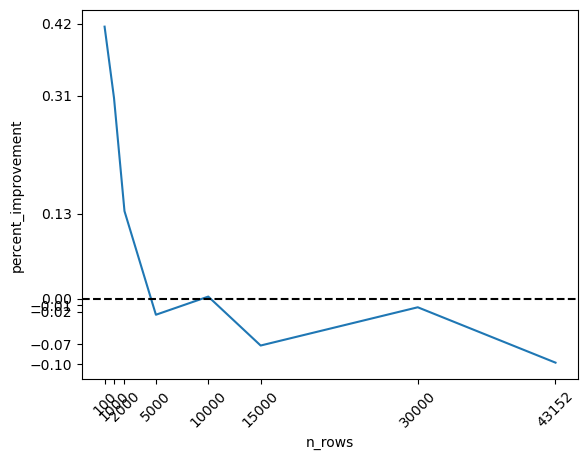

In [33]:
ax = sns.lineplot(data=loss_percent_df, x="n_rows", y="percent_improvement")
plt.axhline(y=0, color="black", linestyle="--")
ax.set_yticks(loss_percent_df["percent_improvement"].round(2))
ax.set_xticks(loss_percent_df["n_rows"])
# ax.set_xscale("log")
# X lables at 45 degree angle
plt.xticks(rotation=45)
# plt.xlabel

In [34]:
xgb_tester(10)

{'n_rows': 10, 'test_loss': 3192334.5919592855}

In [37]:
train_multiple_sizes(
    "models/MTM_PreTrainTesting_ThisOneIsGreat.pt", dataset, 10, n_epochs=250
)

Epoch 78/250 n_rows: 10 Loss: 214,203.48 Test Loss: 7,294,317.00 Early Stopping: Stopped on 20:  31%|███       | 77/250 [00:02<00:04, 36.55it/s]


{'n_rows': 10, 'test_loss': 4829335.5}

In [39]:
3_192_334.5919592855 - 4_829_335.5

-1637000.9080407145